# Autoencoders on Fashionized MNIST

## Imports

In [ ]:
from sklearn.datasets import fetch_openml
from neuralnetlib.utils import train_test_split
from neuralnetlib.models import Autoencoder
from neuralnetlib.layers import *

import matplotlib.pyplot as plt

## Load Fashion MNIST

In [2]:
print("Loading Fashion MNIST...")
X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
X = X.astype('float32') / 255.

X = X.reshape(-1, 28, 28, 1)

X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
print("Dataset shapes:")
print(f"Training data: {X_train.shape}")
print(f"Test data: {X_test.shape}")

Loading Fashion MNIST...


C:\Users\marcp\AppData\Roaming\Python\Python310\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Dataset shapes:
Training data: (56000, 28, 28, 1)
Test data: (14000, 28, 28, 1)


## Create Autoencoder

In [3]:
autoencoder = Autoencoder(random_state=42, skip_connections=True, variational=True)

### Encoder

In [4]:
autoencoder.add_encoder_layer(Input((28, 28, 1)))
autoencoder.add_encoder_layer(Conv2D(16, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'))
autoencoder.add_encoder_layer(Conv2D(32, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'))
autoencoder.add_encoder_layer(Flatten())

# Variational bottleneck (mu, log_var)
autoencoder.add_encoder_layer(Dense(64, activation='linear', name="mu"))  # Mean of latent distribution
autoencoder.add_encoder_layer(Dense(64, activation='linear', name="log_var"))  # Log variance of latent distribution

### Decoder

In [5]:
autoencoder.add_decoder_layer(Dense(7 * 7 * 32, activation='relu'))
autoencoder.add_decoder_layer(Reshape((7, 7, 32)))

autoencoder.add_decoder_layer(UpSampling2D(size=(2, 2)))  # Output: 14x14x32
autoencoder.add_decoder_layer(Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'))

autoencoder.add_decoder_layer(UpSampling2D(size=(2, 2)))  # Output: 28x28x16
autoencoder.add_decoder_layer(Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same'))  # Output: 28x28x1

### Compile

In [6]:
autoencoder.compile(
    encoder_loss='kld',  # Kullback-Leibler divergence
    decoder_loss='mse',  # Reconstruction loss
    encoder_optimizer='adam',
    decoder_optimizer='adam',
    verbose=True
)

Autoencoder(temperature=1.0, gradient_clip_threshold=5.0, enable_padding=False, padding_size=32, random_state=42, skip_connections=True, l1_reg=0.0, l2_reg=0.0)
-------------------------------------------------
Encoder:
Layer 1: Input(input_shape=(28, 28, 1))
Layer 2: Conv2D(num_filters=16, kernel_size=(3, 3), strides=(2, 2), padding=same)
Layer 3: Activation(ReLU)
Layer 4: Conv2D(num_filters=32, kernel_size=(3, 3), strides=(2, 2), padding=same)
Layer 5: Activation(ReLU)
Layer 6: Flatten
Layer 7: Dense(units=64)
Layer 8: Activation(Linear)
Layer 9: Dense(units=64)
Layer 10: Activation(Linear)
-------------------------------------------------
Decoder:
Layer 1: Dense(units=1568)
Layer 2: Activation(ReLU)
Layer 3: Reshape(target_shape=(7, 7, 32), input_shape=None)
Layer 4: UpSampling2D(size=(2, 2), interpolation=nearest)
Layer 5: Conv2D(num_filters=16, kernel_size=(3, 3), strides=(1, 1), padding=same)
Layer 6: Activation(ReLU)
Layer 7: UpSampling2D(size=(2, 2), interpolation=nearest)
Laye

## Train

In [7]:
history = autoencoder.fit(
    X_train,
    epochs=5,
    batch_size=256,
    validation_data=(X_test,),
    verbose=True,
)

[==============================] 100% Epoch 1/5 - loss: 0.1242 -  - 167.57s
[==============================] 100% Epoch 2/5 - loss: 0.1161 -  - 174.12s
[==============================] 100% Epoch 3/5 - loss: 0.1446 -  - 183.64s
[==============================] 100% Epoch 4/5 - loss: 0.1494 -  - 183.82s
[==============================] 100% Epoch 5/5 - loss: 0.1394 -  - 182.60s



## Visualize Original vs Reconstructed Images

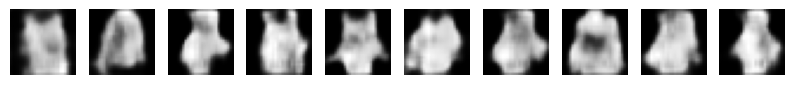

In [8]:
generated_images = autoencoder.generate_image(X_train, n_samples=10, seed=42)

plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()